In [ ]:
import pandas as pd
import argparse
import numpy as np
import pickle

orig_file = "/gpfs/home/lc3424/capstone/2021_dementia/lc3424_workspace/experiments/20211102/volume_label_with_file_path_with_age_20211102.tsv"

orig_file_df = pd.read_csv(orig_file, sep='\t', index_col=0)
orig_file_df


In [ ]:
subjects = list(set(orig_file_df.Subject.to_list()))
len(subjects)

In [ ]:
subjects = np.random.RandomState(seed=42).permuation(subjects, random_state=1)

In [ ]:
train_subject = subjects[:int(len(subject) * .7)]
val_subject = subjects[int(len(subject) * .7): int(len(subject) * .85)]
test_subject = subjects[int(len(subject) * .85):]

In [ ]:
train_df = orig_file_df[orig_file_df.Subject.isin(train_subject)]
val_df = orig_file_df[orig_file_df.Subject.isin(val_subject)]
test_df = orig_file_df[orig_file_df.Subject.isin(test_subject)]

print('Train shape: {}, val shape: {}, test shape: {}'.format(tran_df.shape, val_df.shape, test_df.shape))


In [ ]:
orig_file_name = arguments.orig_file.split('.')[0]
train_df.to_csv(orig_file_name + 'train.tsv', sep='\t')
val_df.to_csv(orig_file_name + 'val.tsv', sep='\t')
test_df.to_csv(orig_file_name + 'test.tsv', sep='\t')

In [ ]:
import pandas as pd
import nibabel as nib
import os
import numpy as np
import matplotlib.pyplot as plt
from nilearn import image
import ants
from datetime import datetime, timedelta
import pydicom as dicom
import pickle
import matplotlib.image as mpimg
from collections import defaultdict, Counter
from scipy import stats

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)

In [ ]:
f1 = '/gpfs/data/razavianlab/data/mri/nyu/barlow_bids_t1_preprocess_lin/subjects/sub-0a2b22da7f004536adef5ac670d443c2/ses-184837540961/t1_linear/sub-0a2b22da7f004536adef5ac670d443c2_ses-184837540961_20111111-SAG_MPR-2_T1w_space-MNI152NLin2009cSym_desc-Crop_res-1x1x1_T1w.nii.gz'
f2 = '/gpfs/data/razavianlab/data/mri/nyu/barlow_bids_t1_preprocess_lin/subjects/sub-0a2b22da7f004536adef5ac670d443c2/ses-184837540961/t1_linear/sub-0a2b22da7f004536adef5ac670d443c2_ses-184837540961_20111111-SAG_MPR-2_T1w_space-MNI152NLin2009cSym_res-1x1x1_affine.mat'
f3 = '/gpfs/data/razavianlab/data/mri/nyu/barlow_bids_t1_preprocess_lin/subjects/sub-0a2b22da7f004536adef5ac670d443c2/ses-184837540961/t1_linear/sub-0a2b22da7f004536adef5ac670d443c2_ses-184837540961_20111111-SAG_MPR-2_T1w_space-MNI152NLin2009cSym_res-1x1x1_T1w.nii.gz'

In [ ]:
# cropped
file = nib.load(f1)
img = file.get_fdata()
plt.imshow(img[:,:,100], cmap='gray')
img.shape

In [ ]:
# not cropped

file = nib.load(f3)
img = file.get_fdata()
plt.imshow(img[:,:,100], cmap='gray')
img.shape

In [ ]:
import torch

In [ ]:
best_model_dir = '/gpfs/home/lc3424/capstone/2021_dementia/lc3424_workspace/experiments/20211102/saved_model/'
model_name = 'age_expansion_8'
pretrained_dict = torch.load(best_model_dir+model_name + '_model_low_loss.pth.tar',map_location='cpu')['state_dict']
pretrained_dict = {k[6:]: v for k, v in pretrained_dict.items() if 'classifier.classifier.LinearClassifier' not in k}
pretrained_dict.keys()

In [ ]:
fc = ['classifier.classifier.LinearClassifier', 'classifier.classifier.LinearClassifier2']

In [ ]:
d = pickle.load(open('res.pkl', 'rb'))
d.keys()

In [ ]:
res = d['res']
out = d['out']

In [ ]:
label = np.argmax(out, axis=1)
label

In [ ]:
# res.drop('Unnamed: 0', axis=1, inplace=True)
res['label_pred'] = label
res[['score_0', 'score_1', 'score_2']] = out
# res.drop('Label', axis=1, inplace=True)
res

In [ ]:
res.label_pred.value_counts()

In [ ]:
res.to_csv('linear_crop_label_predict.tsv', index=False, sep='\t')

# Precision-recall Curve

In [49]:
import pandas as pd
import argparse
import numpy as np
import pickle
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

In [73]:
def pr_curve(file_name, c='AD'):
    def softmax(a, axis=None):
        """
        Computes exp(a)/sumexp(a); relies on scipy logsumexp implementation.
        :param a: ndarray/tensor
        :param axis: axis to sum over; default (None) sums over everything
        """
        from scipy.special import logsumexp
        lse = logsumexp(a, axis=axis)  # this reduces along axis
        if axis is not None:
            lse = np.expand_dims(lse, axis)  # restore that axis for subtraction
        return np.exp(a - lse)

    inp = pickle.load(open(file_name, 'rb'))
    # inp['out'] = softmax(inp['out'], axis=1)
    df2 = pd.concat([inp['res'], pd.DataFrame(inp['out'], columns=['CN', 'MCI', 'AD'])], axis=1)
    c_num = 0
    if c == 'AD':
        c_num = 2
    elif c == 'MCI':
        c_num = 1
    elif c == 'CN':
        c_num = 0
    else:
        raise Exception('exception')

    p, r, _ = precision_recall_curve((df2.Label.to_numpy() == c_num).astype(int), df2[c].to_numpy())
    plt.plot(r, p, lw=2, label=c)

def pr_curve_aggregate(file_name):
    for c in ['CN', 'MCI', 'AD']:
        pr_curve(file_name, c)
    plt.legend(loc="best")
    plt.ylabel('Precision')
    plt.xlabel('Recall')
    plt.title("Precision-recall curve for {}".format(" ".join(file_name.split('/')[-1].split('.')[0].split('_')[1:])))
    plt.savefig("figures/precision_recall_curve_{}.png".format("_".join(file_name.split('/')[-1].split('.')[0].split('_')[1:])), facecolor='white')
    plt.show()

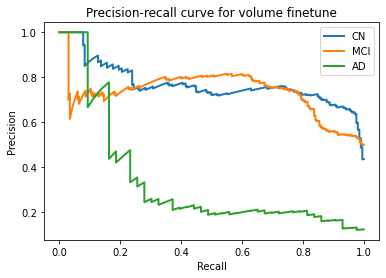

In [76]:
file_name = '/gpfs/home/lc3424/capstone/2021_dementia/lc3424_workspace/experiments/20211102/res_volume_finetune.pkl'
pr_curve_aggregate(file_name)